In [1]:
import os
import json
import time
import math
import random
import numpy as np
from PIL import Image, ImageFilter, ImageOps

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Helpers

In [2]:
class Normalize(object):
    """
    Normalize an image (tensor) with mean and standard deviation. This
    should be just before ToTensor.
    """
    def __init__(self, mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)):
        self.mean = mean
        self.std = std
        
    def __call__(self, sample):
        # Extract PIL image and PIL label from dict
        img = sample['image']
        lab = sample['label']
        
        # Convert PIL data to NumPy array
        img = np.array(img).astype(np.float32)
        lab = np.array(lab).astype(np.float32)
        
        # Normalize img
        img /= 255.0
        img -= self.mean
        img /= self.std
        
        return {'image': img, 'label': lab}
    
    
class ToTensor(object):
    """
    Convert NumPy arrays to PyTorch tensors. This should be 
    the last transformation.
    """
    def __call__(self, sample):
        # Extract PIL image and PIL label from dict
        img = sample['image']
        lab = sample['label']
        
        # Convert PIL data to NumPy array
        img = np.array(img).astype(np.float32)
        lab = np.array(lab).astype(np.float32)
        
        # H x W x C -> C x H x W
        img = img.transpose((2, 0, 1))
        
        # Convert NumPy array to PyTorch tensor
        img = torch.from_numpy(img).float()
        lab = torch.from_numpy(lab).float()
        
        return {'image': img, 'label': lab}
    
    
class FixedResize(object):
    """
    Resizes image and label to a fixed size.
    
    NOTE: Returns data in PIL format
    """
    def __init__(self, size=256):
        self.size = (size, size)
        
    def __call__(self, sample):
        # Extract PIL image and PIL label from dict
        img = sample['image']
        lab = sample['label']
        
        # Resize image and label
        img = img.resize(size=self.size, resample=Image.BILINEAR)
        lab = lab.resize(size=self.size, resample=Image.NEAREST)
        
        return {'image': img, 'label': lab}
    
    
class FixedScaleCrop(object):
    """
    Resizes image and label to a fixed size and then returns
    center cropped image and label
    
    NOTE: Returns data in PIL format
    """
    def __init__(self, crop_size=256):
        self.crop_size = crop_size
        
    def __call__(self, sample):
        # Extract PIL image and PIL label from dict
        img = sample['image']
        lab = sample['label']
        
        # Compute resize width and height
        width, height = img.size
        if width > height:
            resize_h = self.crop_size
            resize_w = int(resize_h * float(width) / height)
        else:
            resize_w = self.crop_size
            resize_h = int(resize_w * float(height) / width)
            
        # Resize image and label
        img = img.resize(size=(resize_w, resize_h), resample=Image.BILINEAR)
        lab = lab.resize(size=(resize_w, resize_h), resample=Image.NEAREST)
        
        # Center crop the resized image
        x1 = int(round(resize_w - self.crop_size) / 2.0)
        y1 = int(round(resize_h - self.crop_size) / 2.0)
        x2 = x1 + self.crop_size
        y2 = y1 + self.crop_size
        
        img = img.crop(box=(x1, y1, x2, y2))
        lab = lab.crop(box=(x1, y1, x2, y2))
        
        return {'image': img, 'label': lab}

# Modified MobileNetV2 for DeepLabV3+

In [3]:
def _make_divisible(v, divisor, min_value=None):
    """
    This function makes sure that number of channels number is divisible by 8.
    Source: https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvBnReLU(nn.Module):
    """
    [CONV]-[BN]-[ReLU6]
    """

    def __init__(self, inCh, outCh, stride):
        super(ConvBnReLU, self).__init__()
        self.inCh = inCh  # Number of input channels
        self.outCh = outCh  # Number of output channels
        self.stride = stride  # Stride
        self.conv = nn.Sequential(
            nn.Conv2d(self.inCh, self.outCh, 3, stride=self.stride, padding=1, bias=False),
            nn.BatchNorm2d(outCh),
            nn.ReLU6(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class InvertedResidual(nn.Module):
    """
    [EXP:CONV_1x1-BN-ReLU6]-[DW:CONV_3x3-BN-ReLU6]-[PW:CONV_1x1-BN] with identity shortcut 
    and dilation.
    """

    def __init__(self, inCh, outCh, t, s, r):
        super(InvertedResidual, self).__init__()
        self.inCh = inCh
        self.outCh = outCh
        self.t = t  # t: expansion factor
        self.r = r  # r: dilation
        if self.r > 1:
            self.s = 1  # s: Stride
            self.padding = self.r  # Atrous Conv padding same as dilation rate
        else:
            self.s = s  # s: Stride
            self.padding = 1
        self.identity_shortcut = (self.inCh == self.outCh) and (self.s == 1)  # L:506 Keras official code

        # Bottleneck block
        self.block = nn.Sequential(
            # Expansition Conv
            nn.Conv2d(self.inCh, self.t * self.inCh, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(self.t * self.inCh),
            nn.ReLU6(inplace=True),

            # Depthwise Conv
            nn.Conv2d(self.t * self.inCh, self.t * self.inCh, kernel_size=3, stride=self.s, padding=self.padding, 
                      dilation=self.r, groups=self.t * self.inCh, bias=False),
            nn.BatchNorm2d(self.t * self.inCh),
            nn.ReLU6(inplace=True),

            # Pointwise Linear Conv (Projection): i.e. No non-linearity
            nn.Conv2d(self.t * self.inCh, self.outCh, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(self.outCh),
        )

    def forward(self, x):
        if self.identity_shortcut:
            return x + self.block(x)
        else:
            return self.block(x)


class PointwiseConv(nn.Module):
    def __init__(self, inCh, outCh):
        super(PointwiseConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(inCh, outCh, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(outCh),
            nn.ReLU6(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


# MobileNetV2
class MobileNetV2(nn.Module):
    """
    MobileNetV2 feature extractor modified to include dilation for DeepLabV3+. 
    NOTE: Last conv Layer and classification layer removed.
    """

    def __init__(self, params):
        super(MobileNetV2, self).__init__()
        self.params = params
        self.first_inCh = 3

        self.c = [_make_divisible(c * self.params.alpha, 8) for c in self.params.c]
        
        # Layer-0
        self.layer0 = nn.Sequential(ConvBnReLU(self.first_inCh, self.c[0], self.params.s[0]))

        # Layer-1
        self.layer1 = self._make_layer(self.c[0], self.c[1], self.params.t[1], self.params.s[1], 
                                       self.params.n[1], self.params.r[1])

        # Layer-2: Image size: 512 -> [IRB-2] -> Output size: 128 (low level feature: 128 * 4 = 512)
        self.layer2 = self._make_layer(self.c[1], self.c[2], self.params.t[2], self.params.s[2], 
                                       self.params.n[2], self.params.r[2])

        # Layer-3
        self.layer3 = self._make_layer(self.c[2], self.c[3], self.params.t[3], self.params.s[3], 
                                       self.params.n[3], self.params.r[3])

        # Layer-4
        self.layer4 = self._make_layer(self.c[3], self.c[4], self.params.t[4], self.params.s[4], 
                                       self.params.n[4], self.params.r[4])

        # Layer-5: Image size: 512 -> [IRB-5] -> Output size: 32, so output stride = 16 achieved
        self.layer5 = self._make_layer(self.c[4], self.c[5], self.params.t[5], self.params.s[5], 
                                       self.params.n[5], self.params.r[5])

        # Layer-6: Apply dilation rate = 2
        self.layer6 = self._make_layer(self.c[5], self.c[6], self.params.t[6], self.params.s[6], 
                                       self.params.n[6], self.params.r[6])

        # Layer-7: Apply dilation rate = 2
        self.layer7 = self._make_layer(self.c[6], self.c[7], self.params.t[7], self.params.s[7], 
                                       self.params.n[7], self.params.r[7])
        
        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, inCh, outCh, t, s, n, r):
        layers = []
        for i in range(n):
            # First layer of each sequence has a stride s and all others use stride 1
            if i == 0:
                layers.append(InvertedResidual(inCh, outCh, t, s, r))
            else:
                layers.append(InvertedResidual(inCh, outCh, t, 1, r))

            # Update input channel for next IRB layer in the block
            inCh = outCh
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        low_level_features = self.layer2(x)  # [512, 512]/4 = [128, 128] 
        x = self.layer3(low_level_features)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        return x, low_level_features
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                

def MobileNet(pretrained=False, **kwargs):
    """
    Constructs a MobileNet V2 model.
    
    Parameters
    ----------
    pretrained: bool, use ImageNet pretrained model or not.
    n_class: int, 1000 classes in ImageNet data.
    weight_file: str, path to pretrained weights
    """
    weight_file = kwargs.pop('weight_file', '')
    model = MobileNetV2(**kwargs)
    if pretrained:
        state_dict = torch.load(weight_file)
        model.load_state_dict(state_dict)
    return model

# Atrous Spatial Pyramid Pooling (ASPP)

In [4]:
class AtrousConvBnRelu(nn.Module):
    """
    [Atrous CONV]-[BN]-[ReLU]
    """
    def __init__(self, inCh, outCh, dilation=1):
        super(AtrousConvBnRelu, self).__init__()
        self.inCh = inCh
        self.outCh = outCh
        self.dilation = dilation
        self.kernel = 1 if self.dilation == 1 else 3
        self.padding = 0 if self.dilation == 1 else self.dilation
        self.atrous_conv = nn.Sequential(
            nn.Conv2d(self.inCh, self.outCh, self.kernel, stride=1, 
                      padding=self.padding, dilation=self.dilation, bias=False), 
            nn.BatchNorm2d(self.outCh),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.atrous_conv(x)
    

class ASPP(nn.Module):
    """
    Atrous Spatial Pyramid Pooling
    
    Ref(s): https://github.com/rishizek/tensorflow-deeplab-v3-plus/blob/master/deeplab_model.py
    and https://github.com/chenxi116/DeepLabv3.pytorch/blob/master/deeplab.py
    """
    def __init__(self, inCh, outCh):
        super(ASPP, self).__init__()
        self.rates = [1, 6, 12, 18] # for output stride 16
        self.inCh = inCh
        self.outCh = outCh
        
        # ASPP layers
        # (a) One 1x1 convolution and three 3x3 convolutions with rates = (6, 12, 18)
        self.conv_1x1_0 = AtrousConvBnRelu(inCh=self.inCh, outCh=self.outCh, 
                                           dilation=self.rates[0])
        self.conv_3x3_1 = AtrousConvBnRelu(inCh=self.inCh, outCh=self.outCh, 
                                           dilation=self.rates[1])
        self.conv_3x3_2 = AtrousConvBnRelu(inCh=self.inCh, outCh=self.outCh, 
                                           dilation=self.rates[2])
        self.conv_3x3_3 = AtrousConvBnRelu(inCh=self.inCh, outCh=self.outCh, 
                                           dilation=self.rates[3])
        
        # (b) The image-level features
        # Global Average Pooling
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
        # CONV-BN-ReLU after Global Average Pooling
        self.conv_bn_relu_4 = nn.Sequential(
            nn.Conv2d(self.inCh, self.outCh, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(self.outCh),
            nn.ReLU(inplace=True)
        )
        
        # CONV-BN-ReLU after Concatenation. NOTE: 5 Layers are concatenated
        self.conv_bn_relu_5 = nn.Sequential(
            nn.Conv2d(self.outCh * 5, self.outCh, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(self.outCh),
            nn.ReLU(inplace=True)
        )
        
        self._initialize_weights()
        
    def forward(self, x):
        x0 = self.conv_1x1_0(x)  # size: [1, outCh, fs, fs]
        x1 = self.conv_3x3_1(x)  # size: [1, outCh, fs, fs]
        x2 = self.conv_3x3_2(x)  # size: [1, outCh, fs, fs]
        x3 = self.conv_3x3_3(x)  # size: [1, outCh, fs, fs]
        
        # Global Average Pooling, CONV-BN-ReLU and upsample
        global_avg_pool = self.global_avg_pooling(x)
        
        x4 = self.conv_bn_relu_4(global_avg_pool)
        
        upsample = F.interpolate(x4, size=(x.size(2), x.size(3)), mode='bilinear', 
                                 align_corners=True)
        
        # Concatinate
        x_concat = torch.cat([x0, x1, x2, x3, upsample], dim=1) # size: [1, 5 * outCh, fs, fs]
        
        # CONV-BN-ReLU after concatination
        out = self.conv_bn_relu_5(x_concat)
        
        return out
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

# Decoder

In [5]:
class Decoder(nn.Module):
    """
    Decoder for DeepLabV3+
    """
    def __init__(self, low_level_inch, low_level_outch, inCh, outCh, n_classes):
        super(Decoder, self).__init__()
        self.low_level_inch = low_level_inch
        self.low_level_outch = low_level_outch # 48 (or lower for speed)
        self.inCh = inCh
        self.outCh = outCh
        self.n_classes = n_classes
        
        # 1x1 Conv with BN and ReLU for low level features
        self.conv_1x1_bn_relu = nn.Sequential(
            nn.Conv2d(self.low_level_inch, self.low_level_outch, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.low_level_outch),
            nn.ReLU(inplace=True)
        )
        
        # Conv block with BN and ReLU (paper suggests to use a few 3x3 Convs, but using only 1
        # for speed improvement) and final Conv 1x1 
        self.conv_block = nn.Sequential(
            nn.Conv2d(self.inCh + self.low_level_outch, self.outCh, kernel_size=3, stride=1, padding=1, 
                      bias=False),
            nn.BatchNorm2d(self.outCh),
            nn.ReLU(inplace=True),
            
            # For reducing number of channels
            nn.Conv2d(self.outCh, self.n_classes, kernel_size=1, stride=1, bias=False)
        )
        
        self._initialize_weights()
    
    def forward(self, x, low_level_features):
        
        # Low level features from MobileNetV2
        low_level_features = self.conv_1x1_bn_relu(low_level_features)
        
        # Upsample features from ASPP by 4
        x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=True)
        
        # Concatinate
        x_concat = torch.cat([x, low_level_features], dim=1)
        
        # Final Convolution
        out = self.conv_block(x_concat)
        
        return out
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

# DeepLabV3+

In [6]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, config):
        super(DeepLabV3Plus, self).__init__()
        self.config = config
        
        # Base Network
        self.base = MobileNet(params=self.config)
        
        # ASPP Module
        self.aspp = ASPP(inCh=self.config.aspp_inch, 
                         outCh=self.config.aspp_outch)
        
        # Decoder
        self.decoder = Decoder(low_level_inch=self.config.low_level_inCh, 
                               low_level_outch=self.config.low_level_outCh, 
                               inCh=self.config.in_channels, 
                               outCh=self.config.out_channels,
                               n_classes=self.config.n_classes)
        
    def forward(self, x):
        # Extract features from base network
        base_out, low_level_features = self.base(x)
        
        # Pool base network output using Atrous Spatial Pyramid Pooling
        aspp_out = self.aspp(base_out)
        
        # Use decoder to obtain object boundaries
        decoder_out = self.decoder(aspp_out, low_level_features)
        
        # Upsample features from decoder by 4
        out = F.interpolate(decoder_out, scale_factor=4, mode='bilinear', align_corners=True)
        
        return out

# Config

In [7]:
class Config():
    """
    Configuration for training DeepLabV3+
    """
    def __init__(self):
        # MobileNetV2 parameters
        # ----------------------
        # Conv and Inverted Residual Parameters: Table-2 (https://arxiv.org/pdf/1801.04381.pdf)
        self.t = [1, 1, 6, 6, 6, 6, 6, 6]  # t: expansion factor
        self.c = [32, 16, 24, 32, 64, 96, 160, 320]  # c: Output channels
        self.n = [1, 1, 2, 3, 4, 3, 3, 1]  # n: Number of times layer is repeated
        self.s = [2, 1, 2, 2, 2, 1, 2, 1]  # s: Stride
        self.r = [1, 1, 1, 1, 1, 1, 2, 2]  # r: Dilation (added to take care of dilation)
        # Width multiplier: Controls the width of the network
        self.alpha = 1 # Use multiples of 0.25, min=0.25, max=1.0
        
        # Data Augmentations 
        # ------------------
        self.img_mean = [0.485, 0.456, 0.406]
        self.img_std = [0.229, 0.224, 0.225]
        self.image_size = 512  # Crop size
        
        # ASPP Parameters
        # ---------------
        self.aspp_inch = int(self.alpha * self.c[-1])  # Width multiplier * 320
        self.aspp_outch = int(self.alpha * 256)  # Width multiplier * 256
        
        # Decoder Parameters
        # ------------------
        self.n_classes = 19
        self.low_level_inCh = _make_divisible(self.alpha * self.c[2], 8) # Width multiplier * 32
        self.low_level_outCh = int(2 * self.low_level_inCh)  # 2 * low level features channels
        self.in_channels = _make_divisible(self.alpha * 256, 8) # Width multiplier * 256
        self.out_channels = _make_divisible(self.alpha * 256, 8) # Width multiplier * 256
        
        # Checkpoint config
        # -----------------
        self.checkpoint_path = './checkpoints/MobileNetV2_DeepLabV3Plus.pth.tar'
        
config = Config()

# Inference Helpers

In [8]:
class_to_color_map = {
    'Road': (135, 135, 135),  # Medium Grey
    'Sidewalk': (224, 224, 224),  # Light Grey
    'Building': (255, 237, 160),  # Pastel Yellow
    'Wall': (245, 222, 179), # Pastel Brown
    'Fence': (247, 252, 185),  # Pastel Green
    'Pole': (190, 153, 153),  # Pastel Burgundy
    'Traffic Light': (255, 127, 0),  # Orange
    'Traffic Sign': (255, 255, 51),  # Yellow
    'Vegetation': (51, 160, 44),  # Green
    'Terrain': (191, 129, 45),  # Medium Brown
    'Sky': (135, 206, 250),  # Light Blue
    'Person': (227, 26, 28),  # Red
    'Rider': (252, 146, 114),  # Pastel Red
    'Car': (30, 144, 255),  # Blue
    'Truck': (106, 61, 154),  # Purple
    'Bus': (102, 194, 164),  # Green Blue
    'Train': (70, 130, 180), # Pastel Blue
    'Motorcycle': (103, 0, 13),  # Dark Brown
    'Bicycle': (231, 41, 138),  # Pink 
}

class_id_to_name_map = {
    0: 'Road', 
    1: 'Sidewalk', 
    2: 'Building', 
    3: 'Wall', 
    4: 'Fence', 
    5: 'Pole', 
    6: 'Traffic Light', 
    7: 'Traffic Sign', 
    8: 'Vegetation', 
    9: 'Terrain', 
    10: 'Sky', 
    11: 'Person', 
    12: 'Rider', 
    13: 'Car', 
    14: 'Truck', 
    15: 'Bus', 
    16: 'Train', 
    17: 'Motorcycle', 
    18: 'Bicycle'}

class_id_to_color = {i: class_to_color_map[name] for i, name in class_id_to_name_map.items()}
print(class_id_to_color)

{0: (135, 135, 135), 1: (224, 224, 224), 2: (255, 237, 160), 3: (245, 222, 179), 4: (247, 252, 185), 5: (190, 153, 153), 6: (255, 127, 0), 7: (255, 255, 51), 8: (51, 160, 44), 9: (191, 129, 45), 10: (135, 206, 250), 11: (227, 26, 28), 12: (252, 146, 114), 13: (30, 144, 255), 14: (106, 61, 154), 15: (102, 194, 164), 16: (70, 130, 180), 17: (103, 0, 13), 18: (231, 41, 138)}


width: 1960, height: 1102


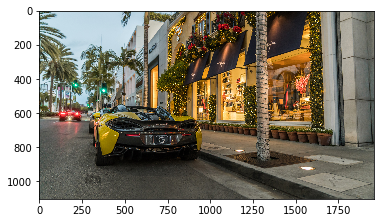

In [9]:
# Read Image
side = 512
img_path = './example-1.jpg'
img = Image.open(img_path)

width, height = img.size
print('width: {}, height: {}'.format(width, height))
plt.imshow(img)

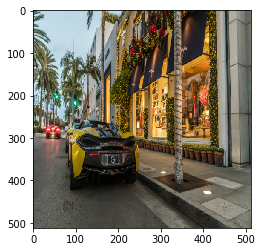

In [10]:
img = img.resize(size=(512, 512), resample=Image.BILINEAR)
plt.imshow(img)

In [11]:
img = np.array(img)/255.0
        
# If image is gray scale then add channels
if len(img.shape) == 2:
    img = img[:, :, np.newaxis]
    img = np.concatenate([img, img, img], axis=2)
    
print(img.shape)
# Normalize img
img -= np.array([0.485, 0.456, 0.406])
img /= np.array([0.229, 0.224, 0.225])

img = img.transpose(2, 0, 1)  # PyTorch: [C, W, H]
img = torch.from_numpy(img).float().unsqueeze(0)
print(img.shape)

(512, 512, 3)
torch.Size([1, 3, 512, 512])


In [12]:
model = DeepLabV3Plus(config=config)
state_dict = torch.load('./checkpoints/MobileNetV2_DeepLabV3Plus.pth.tar')
model.load_state_dict(state_dict['model'])
model.eval()
print('Model Loaded!')

Model Loaded!


In [13]:
out = model(img)
out = out.squeeze(0)
print(out.shape)

torch.Size([19, 512, 512])


In [14]:
pred = F.softmax(out, dim=0)
print(pred.shape)

torch.Size([19, 512, 512])


In [15]:
# Find indices with maximum value
pred = torch.argmax(pred, dim=0)
pred = pred.numpy()
print(pred.shape)

(512, 512)


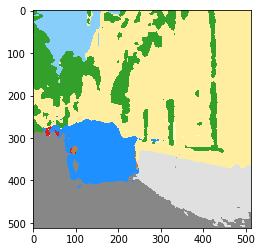

In [16]:
color_img = np.zeros((pred.shape[0], pred.shape[1], 3))

for idx, color in class_id_to_color.items():
    color_img[pred == idx] = np.array(color)
    
color_img = color_img.astype(np.uint8)
plt.imshow(color_img) 

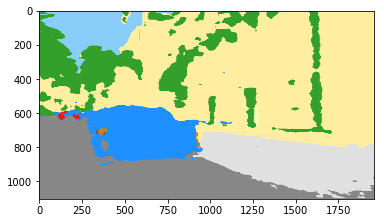

In [17]:
color_img = Image.fromarray(color_img)
os_img = color_img.resize(size=(width, height), resample=Image.BILINEAR)
plt.imshow(os_img)

In [18]:
ori_img = np.array(Image.open(img_path))
mask = np.array(os_img)

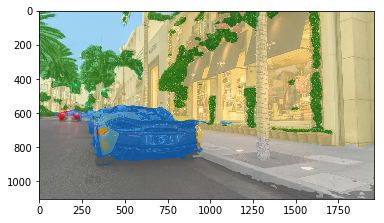

In [19]:
output = ((0.4 * ori_img) + (0.6 * mask)).astype("uint8")
plt.imshow(output)

In [20]:
# mask = cv2.resize(mask, (image.shape[1], image.shape[0]),
# 	interpolation=cv2.INTER_NEAREST)
# classMap = cv2.resize(classMap, (image.shape[1], image.shape[0]),
# 	interpolation=cv2.INTER_NEAREST)
 
# # perform a weighted combination of the input image with the mask to
# # form an output visualization
# output = ((0.4 * image) + (0.6 * mask)).astype("uint8")

In [21]:
#Overlay https://www.pyimagesearch.com/2018/09/03/semantic-segmentation-with-opencv-and-deep-learning/